This is an example notebook for the computation of the cosmic shear correlation functions.

Goals: modify the notebook so that the cosmology is done with DISCO-DJ and the lensing weight functions (and everything after that) are binned in redshift.

**Authors**: Pierre Fleury, Natalie Hogg

In [1]:
# Load packages, including CAMB
%matplotlib inline
import sys, platform, os
import matplotlib.pyplot as plt

plt.style.use('sanglier')

#from scipy import constants, special, integrate, stats
import numpy as np
from scipy.interpolate import CubicSpline, RegularGridInterpolator
from scipy import integrate
from hankel import HankelTransform

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
from camb.correlations import cl2corr
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.4 installed at /home/nataliehogg/anaconda3/lib/python3.11/site-packages/camb


In [2]:
def radtoarcmin(angle_rad):
    """
    This function converts an an angle expressed in radians
    into arcmins.
    """
    
    angle_arcmin = angle_rad * 60 * 180 / np.pi
    
    return angle_arcmin


def arcmintorad(angle_arcmin):
    """
    This function converts an an angle expressed in arcmins
    into radians.
    """
    
    angle_rad = angle_arcmin / (60 * 180 / np.pi)
    
    return angle_rad

# Weyl power spectrum from CAMB

This is the step to compute $P_W(k, z)$, which in CAMB's convention is 
$$
P_W(k, z) = \left(\frac{3}{2} H_0^2\Omega_{\rm m}\right)^2 (1+z)^2 P_{\rm m}(k, z)
$$

In [3]:
# CAMB parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.37, ombh2=0.0223, omch2=0.1198)
pars.InitPower.set_params(ns=0.965)
background = camb.get_background(pars)

In [4]:
# Compute Weyl power spectrum
zmax = 7
kmax = 5e2 #(inverse Mpc)
extrap_kmax = 1e10
Weyl_power_spectra = camb.get_matter_power_interpolator(pars, zmax=zmax, kmax=kmax, zs=None,
hubble_units=False, k_hunit=False, var1=model.Transfer_Weyl, var2=model.Transfer_Weyl, extrap_kmax=extrap_kmax)

matter_power_spectra = camb.get_matter_power_interpolator(pars, zmax=zmax, kmax=kmax)

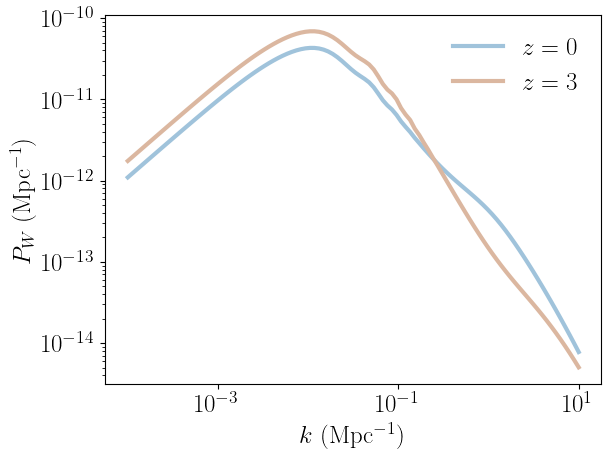

In [5]:
k = np.logspace(-4, 1, 100)

zplot = [0, 3]
for z in zplot:
    plt.loglog(k, Weyl_power_spectra.P(z,k), lw=3)
plt.xlabel('$k$ (Mpc$^{-1}$)')
plt.ylabel('$P_W$ (Mpc$^{-1}$)')
plt.legend(['$z=%s$'%z for z in zplot], frameon=False);

# Weyl power spectrum from DISCO-DJ

In [6]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp

from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, get_power

In [7]:
@jax.jit
def compute_matter_power(sigma8_fid):
    param = {}
    param['Omegam']  = 0.301            # Total matter density parameter
    param['Omegab']  = 0.0488911         # Baryon density parameter
    param['w_DE_0']  = -0.99             # Dark energy equation of state parameter today
    param['w_DE_a']  = 0.0               # Dark energy equation of state parameter time derivative
    param['cs2_DE']  = 1.0               # Dark energy sound speed squared
    param['Omegak']  = 0.0               # Omega_DE computed directly thanks to this assumption
    param['A_s']     = 2.1064e-09        # Scalar amplitude of the primordial power spectrum
    param['n_s']     = 0.96822           # Scalar spectral index
    param['H0']      = 67.742            # Hubble constant today in units of 100 km/s/Mpc
    param['Tcmb']    = 2.7255            # CMB temperature today in K
    param['YHe']     = 0.248             # Helium mass fraction
    param['Neff']    = 2.046             # Effective number of ultrarelativistic neutrinos; -1 for massive neutrinos
    param['Nmnu']    = 1                 # Number of massive neutrinos (must be 1 currently)
    param['mnu']     = 0.06              # Sum of neutrino masses in eV 
    param['k_p']     = 0.05              # Pivot scale in 1/Mpc
    
#     param['sigma8'] = sigma8_fid
    
    # modes to sample
    nmodes = 512                         # 512; number of modes to sample
    kmin   = 1e-4                        # 1e-4; minimum k in 1/Mpc
    kmax   = 10                           # 10; maximum k in 1/Mpc
    aexp   = 1.0                         # scale factor at which to evaluate the power spectrum
  
    # Compute Background+thermal evolution
    param = evolve_background(param=param, thermo_module='RECFAST')
    
    # compute perturbation evolution
    aexp_out = jnp.array([aexp])
    y, kmodes = evolve_perturbations(param=param, kmin=kmin, kmax=kmax, 
                                     num_k=nmodes, aexp_out=aexp_out, 
                                     rtol=1e-3, atol=1e-3)
    
    # turn perturbations into power spectra
    Pkm = get_power( k=kmodes, y=y[:,0,:], idx=4, param=param )
    
    return Pkm, kmodes

In [8]:
Pkm, kmodes = compute_matter_power(0.8)

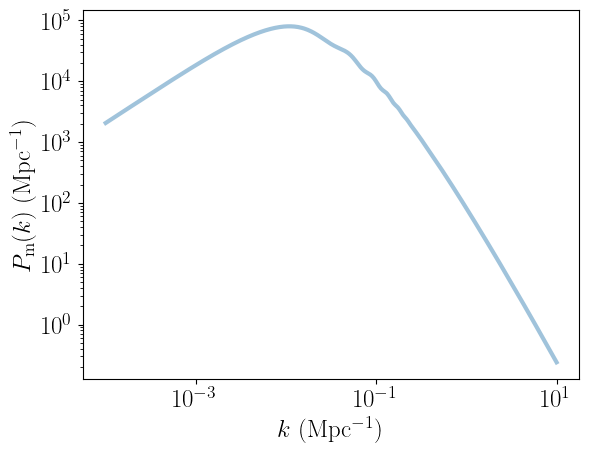

In [9]:
plt.plot(kmodes, Pkm, lw=3)
plt.loglog()
plt.xlabel('$k$ (Mpc$^{-1}$)')
plt.ylabel(r'$P_{\rm m}(k)$ (Mpc$^{-1}$)')
plt.show()

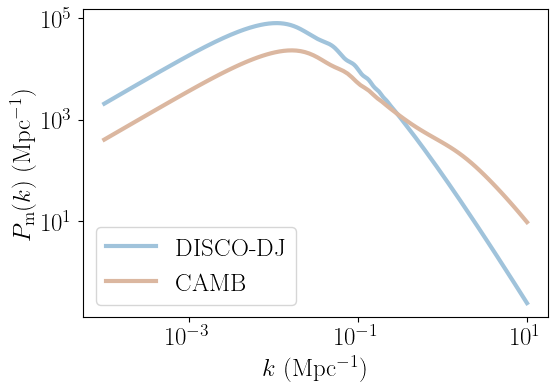

In [10]:
# compare CAMB and DISCO-DJ output

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(kmodes, Pkm, lw=3, label = 'DISCO-DJ')
ax.loglog(k, matter_power_spectra.P(0,k), lw=3, label = 'CAMB')
ax.set_xlabel('$k$ (Mpc$^{-1}$)')
ax.set_ylabel(r'$P_{\rm m}(k)$ (Mpc$^{-1}$)')
ax.legend()
plt.show()

In [21]:
clight = 3e8
H0 = 67
Omega_m = 0.3
z_fiducial = 0
prefactor = (((3/2)*(H0**2/clight**2)*Omega_m)**2)*((1+z_fiducial)**2)
Pk_weyl = Pkm/prefactor

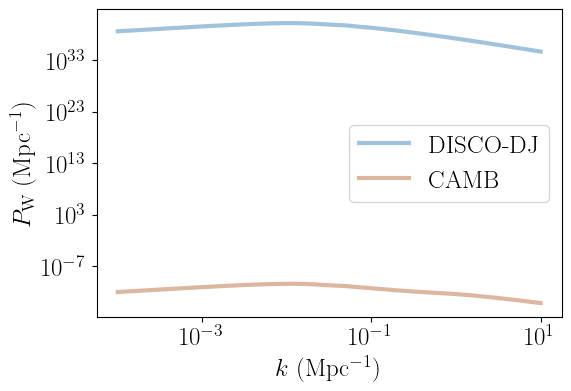

In [22]:
# compare CAMB and DISCO-DJ output

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(kmodes, Pk_weyl, lw=3, label = 'DISCO-DJ')
ax.loglog(k, Weyl_power_spectra.P(0,k), lw=3, label = 'CAMB')
ax.set_xlabel('$k$ (Mpc$^{-1}$)')
ax.set_ylabel(r'$P_{\rm W}$ (Mpc$^{-1}$)')
ax.legend()
plt.show()

In [13]:
print(Pk_weyl[0])
print(Weyl_power_spectra.P(0,0.1))

0.0005047747947594137
5.9776002949332175e-12


In [14]:
assert False

AssertionError: 

# Lensing weight functions

*To be improved*: For the moment there is no binning.

This should compute for each redshift bin $I$ the weight function $q_I(\chi)$ defined as
$$
q_I(\chi) = \int_\chi^\infty \mathrm{d}\chi_* \, \frac{\chi_* - \chi}{\chi} \, p_I(\chi_*) \ ,
$$
where $p_I(\chi)$ is the PDF of comoving distance in the $I$th bin. In the following cells the binning remains to be done, and $p$ is taken to be the full redshift PDF of Euclid.

In [ ]:
def redshift_distribution_Euclid(z):
    """
    This is the total redshift distribution of galaxies
    expected from the Euclid survey.
    Source: eq. (10) of https://arxiv.org/pdf/2010.07376.pdf
    """
    
    a = 0.4710
    b = 5.1843
    c = 0.7259
    A = 1.75564 # ensures normalisation to 1
    
    n = A * (z**a + z**(a*b)) / (z**b + c)
    
    return n

In [ ]:
z = np.linspace(0, 6, 100)
n = redshift_distribution_Euclid(z)

plt.plot(z, n, label='Euclid galaxies')
plt.xlabel('galaxy redshift')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [ ]:
def get_q_Euclid(zmax=6, nchi=1000):
    """
    Compute the lensing efficiency function for all galaxy Euclid bins together,
    as a function of comoving distance chi, in Mpc.
    """
    
    chimax = background.comoving_radial_distance(zmax)
    
    # define the q integral
    def q_integral(chi):
        
        z = background.redshift_at_comoving_radial_distance(chi)
        
        def integrand(zs):
            chis = background.comoving_radial_distance(zs)
            ps = redshift_distribution_Euclid(zs)
            return (1 - chi / chis) * ps
            
        q, err = integrate.quad(integrand, z, zmax)
        return q
    
    # interpolate
    chi_sample = np.linspace(0, chimax, nchi)
    q_sample = [q_integral(chi) for chi in chi_sample]
    q_sample = np.array(q_sample)
    #for chi in chi_sample:
    #    q = q_integral(chi)
    #    q_sample.append(q)
    #q_sample = np.array(q_sample)
    
    q_func = CubicSpline(chi_sample, q_sample)
    
    return q_func

In [ ]:
q_Euclid_intp = get_q_Euclid()

In [ ]:
chi = np.linspace(0,10000,100)

In [ ]:
plt.plot(chi, chi * q_Euclid_intp(chi), label=r'$\chi q(\chi)$')
plt.xlabel(r'comoving distance $\chi$ [Mpc]')
plt.ylabel(r'lensing efficiency [Mpc]')
plt.legend(frameon=False)
plt.show()

# Shear angular power spectrum

To be modified to include binning. The formula is obtained using Limber's approximation, and the angular power spectrum for redshift bins $I, J$ reads
$$
C_\ell^{IJ}
=
\int_0^\infty \mathrm{d}\chi \; q_I(\chi) q_J(\chi) \, P_W\left[\frac{\ell+1/2}{\chi}, z(\chi)\right]
$$

In [ ]:
def get_cls_shear(chimax, lmax, nl):
    """
    This function generates Cls for convergence and shear
    It takes as argument the maximum multipole lmax.
    nl is the number of values to be computed.
    """
    
    nz = 100 #number of elements for discrete integral along the los
    
    # Conformal distances and redshifts
    results = camb.get_background(pars)
    chis = np.linspace(0, chimax, nz)
    zs = results.redshift_at_comoving_radial_distance(chis)
    
    # Array of delta_chi, and drop first and last points where things go singular
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    
    # Lensing kernel (here normal shear)
    kernel = q_Euclid_intp(chis)**2
    
    # Integration over chi
    lmin = 1
    ls = np.logspace(np.log10(lmin), np.log10(lmax), nl)
    cl = np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    
    # Check that lmax is not too big
    if lmax > extrap_kmax * chis[-1]:
        print("""Warning: lmax is too large given the range of extrapolation given to CAMB
for the power spectrum. The results cannot be trusted.""")
    
    for i, l in enumerate(ls):
        k = (l + 0.5)/chis
        w[:] = 1
        w[k<1e-4] = 0
        w[k>=extrap_kmax] = 0
        cl[i] = np.dot(dchis, w * Weyl_power_spectra.P(zs, k, grid=False) * kernel)
        
    return ls, cl

In [ ]:
lmax = 1e8
nl = 1000
chimax = max(chi)
ls, cl = get_cls_shear(chimax, lmax, nl)
cl_intp = CubicSpline(ls, cl)

In [ ]:
plt.loglog(ls, ls**2*cl_intp(ls)/(2*np.pi))
plt.ylabel(r'$\ell^2\,C_\ell^{\gamma}/2\pi$')
plt.xlabel(r'$\ell$')
plt.show()

# Shear correlation functions

*To be modified to include binning*. We compute the plus and minus correlation functions from the angular power spectrum in the flat-sky approximation. In that framework the correlation functions are Hankel transforms of the angular power spectrum. For the redshift bins $I, J$,
\begin{align}
\xi_+^{IJ}(\theta)
&=
\int_0^\infty \frac{\ell\mathrm{d}\ell}{2\pi} \, J_0(\ell \theta) C^{IJ}_\ell \ ,
\\
\xi_-^{IJ}(\theta)
&=
\int_0^\infty \frac{\ell\mathrm{d}\ell}{2\pi} \, J_4(\ell \theta) C^{IJ}_\ell \ ,
\end{align}
where $J_n(x)$ are Bessel functions.

In [ ]:
def get_correlations(cl_intp, Thetamin, Thetamax, nTheta=1000):
    """
    Generates the + and - correlation functions from the angular power spectrum
    using Hankel transformations, for a range of apertures [Thetamin, Thetamax]
    expressed in radians.
    The first argument is the interpolation of the cls.
    It returns the correlation functions as arrays.
    """
    
    # initialise Hankel transforms
    ht0 = HankelTransform(nu=0, N=1e4, h=1e-3) # for xi_plus
    ht4 = HankelTransform(nu=4, N=1e4, h=1e-3) # for xi_minus
    
    # define angular domain
    #logThetamin = np.log10(Thetamin)
    #logThetamax = np.log10(Thetamax)
    #nTheta = 100 * int(logThetamax - logThetamin) # 100 points per decade
    #Theta = np.logspace(logThetamin, logThetamax, nTheta) # separation angles, in arcmin
    #nTheta = 1000 # number of points
    #Theta = np.linspace(Thetamin, Thetamax, nTheta)
    logThetamin = np.log10(Thetamin)
    logThetamax = np.log10(Thetamax)
    Theta = np.logspace(logThetamin, logThetamax, nTheta)
    Theta = np.append([0], Theta)
    #print(Theta)
    xi_plus = ht0.transform(cl_intp, Theta, ret_err=False)/(2*np.pi)
    xi_minus = ht4.transform(cl_intp, Theta, ret_err=False)/(2*np.pi)
    
    return Theta, xi_plus, xi_minus

In [ ]:
Thetamin = arcmintorad(1)
Thetamax = np.pi
nTheta = 1000

Theta, xi_plus, xi_minus = get_correlations(
    cl_intp, Thetamin, Thetamax, nTheta)

In [ ]:
Theta_arcmin = radtoarcmin(Theta)

# Plus correlations
plt.plot(Theta_arcmin,
         Theta_arcmin * xi_plus * 1e4, label=r'$\xi^+_{\gamma}$')
# Minus correlations
plt.plot(Theta_arcmin,
         Theta_arcmin * xi_minus * 1e4, label=r'$\xi^-_{\gamma}$')
plt.xlabel(r'angular separation $\Theta$ (arcmin)')
plt.ylabel(r'$\Theta\,\xi^\pm_{\gamma}$ ($10^{-4}$ arcmin)')
plt.legend(frameon=False)
plt.show()

In [ ]:
Theta = np.linspace(Thetamin, Thetamax, nTheta)
xvals = np.cos(Theta)

In [ ]:
print(cl)

In [ ]:
my_corr = camb.correlations.cl2corr(np.array([ls, cl[0]]), np.array(xvals), lmax=10)

In [ ]:
xi_plus_intp = CubicSpline(Theta, xi_plus)
xi_minus_intp = CubicSpline(Theta, xi_minus)

# Angular binning

In [ ]:
class GalaxyDistribution:
    """
    This class produces anything useful related to the statistics of galaxies
    and their binning by angular separation.
    """
    
    
    def __init__(self, Ngal=1e9, sky_coverage=15e3, Nbin=10, Thetamax=3e2):
        """
        Arguments:
        - Ngal: number of galaxies we can use
        - sky_coverage: area of the survey footprint, in deg2 
        - Nbin: number of bins of angular separation
        - Thetamax: maximum angular separation, in arcmin
        
        All the angular attributes will be converted in rad.
        """
        
        # Galaxy number and density
        self.Ngal = Ngal
        self.Omegatot = sky_coverage * (np.pi / 180)**2 # in rad2
        self.density = Ngal / self.Omegatot
        
        # Binning
        self.Nbin = Nbin
        Omega_arcmin2 = np.pi * Thetamax**2 / Nbin
        self.Omega = Omega_arcmin2 * (np.pi / 180 / 60)**2 # in rad2
        self.Omegas = self.Omega * np.ones(Nbin) # in rad2
        # the list of Omegas is in case we want to have different bin sizes
        self.limits = np.sqrt(self.Omega / np.pi * np.arange(Nbin + 1)) # in rad
        
        # "Centres" of the bins, taken as the median separation
        self.Thetas = np.sqrt((self.limits[1:]**2 + self.limits[:-1]**2) / 2) # in rad
        
        
    def compute_binned_correlations(self):
        """
        This function computes the expected signal for the shear
        autocorrelation with this binning.
        """
        
        xi_plus_bins  = []
        xi_minus_bins = []
        
        Nbin   = self.Nbin
        rs     = self.limits
        Omegas = self.Omegas
    
        for a in range(Nbin):

            # xi_plus

            def integrand(r):
                f = 2 * np.pi * r * xi_plus_intp(r)
                return f

            integral, err = integrate.quad(integrand, rs[a], rs[a+1])
            integral /= Omegas[a]
            xi_plus_bins.append(integral)

            # xi_minus

            def integrand(r):
                f = 2 * np.pi * r * xi_minus_intp(r)
                return f

            integral, err = integrate.quad(integrand, rs[a], rs[a+1])
            integral /= Omegas[a]
            xi_minus_bins.append(integral)
            
        return xi_plus_bins, xi_minus_bins

In [ ]:
# I have chosen those numbers arbitarily. To be checked
Ngal = 1e9
sky_coverage = 15e3
Nbin = 10
Thetamax = 300

gal_dist = GalaxyDistribution(Ngal, sky_coverage, Nbin, Thetamax)
Thetas = gal_dist.Thetas

# binned signal
xi_shear_plus_binned, xi_shear_minus_binned = gal_dist.compute_binned_correlations()

In [ ]:
Theta_arcmin = radtoarcmin(Thetas)

plt.semilogy(Theta_arcmin, xi_shear_plus_binned, 'o-', label=r"$\xi^+_{\gamma}(a)$")
plt.semilogy(Theta_arcmin, xi_shear_minus_binned, 'o-', label=r"$\xi^-_{\gamma}(a)$")
plt.xlabel(r"bin median separation $\bar{\Theta}_a$ [arcmin]")
plt.ylabel(r"binned correlation functions")
plt.legend(frameon=False)
plt.show()